# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [114]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torch.utils.data import Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [199]:
def train_epoch(model, dataloader, criterion, optimizer, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    return avg_loss


def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.eval()
    losses = []
    predictions = []
    true_labels = []
    with torch.no_grad():
        for (inputs, labels) in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())
            losses.append(loss.item())
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(np.hstack(true_labels), np.hstack(predictions))
    report = classification_report(np.hstack(true_labels), np.hstack(predictions), zero_division=0, digits=3)
    return avg_loss, accuracy, report


def plot_validation_curves(losses_and_accs, fig_path):
    train_losses = [x for (x, _, _) in losses_and_accs]
    val_losses = [x for (_, x, _) in losses_and_accs]
    accs = [x for (_, _, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {round(np.max(accs), 2)} @ epoch {np.argmax(accs)}')
    plt.savefig(fig_path)

In [117]:
ood = 'cifar100'  # or fakedata

In [292]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

id_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

if ood == 'fakedata':
  fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
  fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False)

if ood == 'cifar100':
  ood_classes = ["aquarium", "bycicle", "bottle", "bed", "rocket", "can", "girl", "chair"]
  cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
  selected_indices = [i for i, (_, label) in enumerate(cifar100) if cifar100.classes[label] in ood_classes]
  fakeset = Subset(cifar100, selected_indices)
  fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False)

In [293]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [120]:
# run it to train the cnn

model = CNN().to(device)
loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
for e in range(epochs):
    train_epoch(model, trainloader, loss, optimizer, epoch=e, device=device)
    val_loss, val_acc, val_report = evaluate_model(model, testloader, loss, device=device)
    print(f'Epoch {e} - Validation Loss: {val_loss} - Validation Accuracy: {val_acc}')

torch.save(model.state_dict(), './model_weights/cifar10_cnn.pth')

Training epoch 0: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s]


Epoch 0 - Validation Loss: 1.519564974157116 - Validation Accuracy: 0.4498


Training epoch 1: 100%|██████████| 391/391 [00:26<00:00, 14.93it/s]


Epoch 1 - Validation Loss: 1.3969672329818146 - Validation Accuracy: 0.4903


Training epoch 2:  14%|█▎        | 53/391 [00:03<00:23, 14.40it/s]


KeyboardInterrupt: 

In [294]:
# run to load the pretrained cnn

model = CNN().to(device)
model.load_state_dict(torch.load('./model_weights/cifar10_CNN_50_0.0001.pth', map_location=device))

<All keys matched successfully>

In [103]:
# run it to load the pretrained resnet
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.to(device)

Using cache found in C:\Users\bizza/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [295]:
_, test_acc, report = evaluate_model(model, testloader, loss, device=device)
print(f'Test Accuracy: {test_acc}')
print(report)

Test Accuracy: 0.6403
              precision    recall  f1-score   support

           0      0.699     0.722     0.710      1000
           1      0.774     0.796     0.785      1000
           2      0.576     0.476     0.521      1000
           3      0.431     0.514     0.469      1000
           4      0.516     0.613     0.560      1000
           5      0.555     0.490     0.520      1000
           6      0.684     0.711     0.697      1000
           7      0.733     0.641     0.684      1000
           8      0.730     0.790     0.759      1000
           9      0.765     0.650     0.703      1000

    accuracy                          0.640     10000
   macro avg      0.646     0.640     0.641     10000
weighted avg      0.646     0.640     0.641     10000


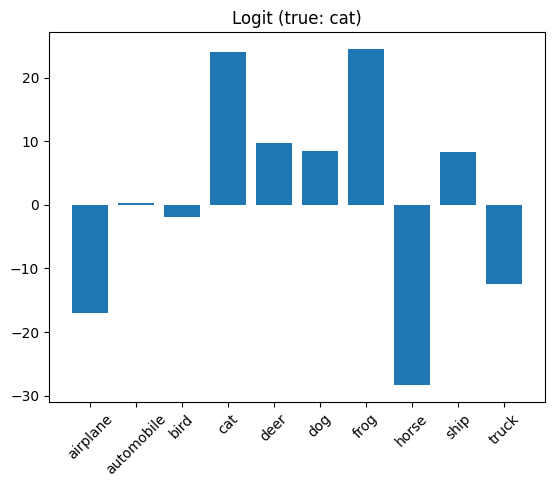

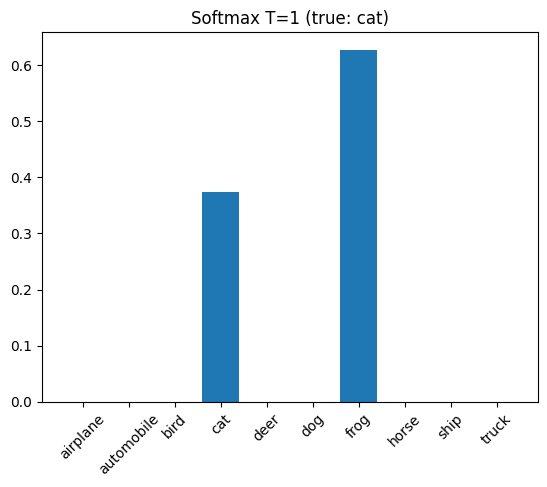

In [296]:
# Example of logit and softmax output (ID data)

x, y = next(iter(testloader))
x, y = x.to(device), y.to(device)

true_label = testset.classes[y[0]]

output = model(x)

# logits
plt.bar(np.arange(10), output[0].detach().cpu())
plt.title(f'Logit (true: {true_label})')
plt.xticks(np.arange(10), testset.classes, rotation=45)
plt.show()

# softmax
T = 1
s = F.softmax(output/T, dim=1)

plt.bar(np.arange(10), s[0].detach().cpu())
plt.title(f'Softmax T={T} (true: {true_label})')
plt.xticks(np.arange(10), testset.classes, rotation=45)
plt.show()

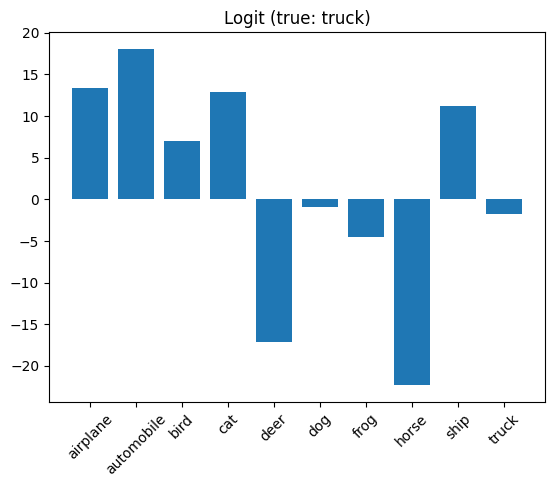

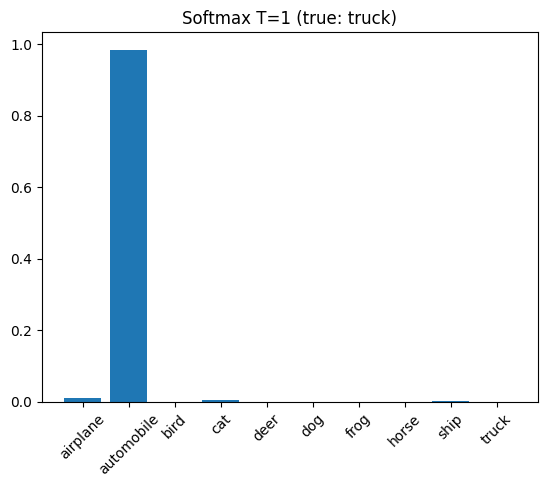

In [297]:
# Example of logit and softmax output (OOD data)

x, y = next(iter(fakeloader))
x, y = x.to(device), y.to(device)

true_label = testset.classes[y[0]]

output = model(x)

# logits
plt.bar(np.arange(10), output[0].detach().cpu())
plt.title(f'Logit (true: {true_label})')
plt.xticks(np.arange(10), testset.classes, rotation=45)
plt.show()

# softmax
T = 1
s = F.softmax(output/T, dim=1)

plt.bar(np.arange(10), s[0].detach().cpu())
plt.title(f'Softmax T={T} (true: {true_label})')
plt.xticks(np.arange(10), testset.classes, rotation=45)
plt.show()

In [298]:
def max_logit(logit):
    s = logit.max(dim=1)[0]  #get the max for each element of the batch
    return s


def max_softmax(logit, T=1.0):
    s = F.softmax(logit / T, 1)
    s = s.max(dim=1)[0]  #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

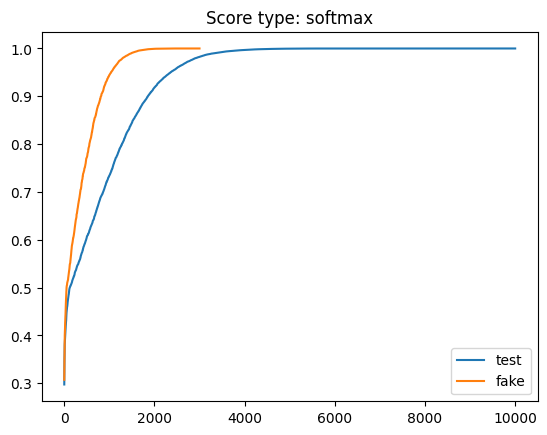

In [299]:
temp = 1
score_type = "softmax"  

if score_type == "softmax":
    score_fun = lambda l: max_softmax(l, T=temp)
elif score_type == "logit":
    score_fun = max_logit


scores_test = compute_scores(testloader, score_fun)
scores_fake = compute_scores(fakeloader, score_fun)

plt.plot(sorted(scores_test.cpu()), label='test')
plt.plot(sorted(scores_fake.cpu()), label='fake')
plt.title(f"Score type: {score_type}")
plt.legend()
plt.show()

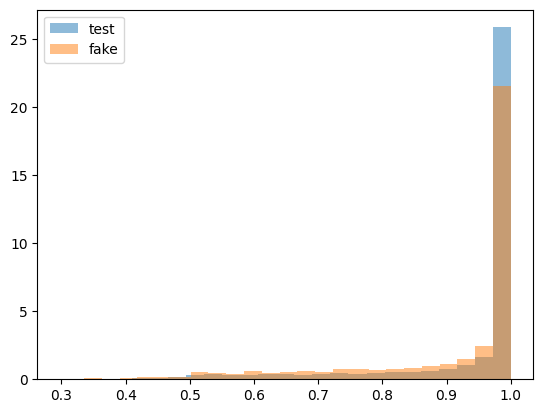

In [300]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



In [301]:
prediction = torch.cat((scores_test, scores_fake))
target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))

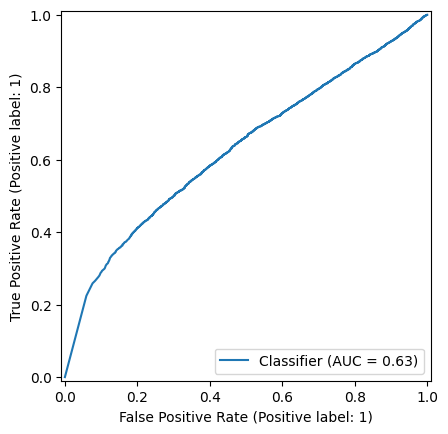

In [302]:
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

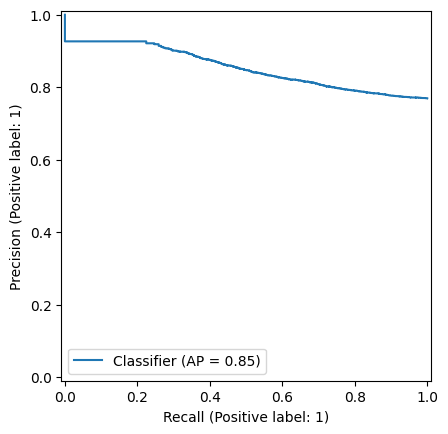

In [303]:
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [143]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [263]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [173]:
def fgsm_attack(model, loss_fn, input_image, true_label, epsilon, max_iterations=10):
    original_image = input_image.clone().detach()
    adversarial_image = input_image.clone().detach()
    adversarial_image.requires_grad = True

    output = model(adversarial_image.unsqueeze(0))
    predicted_label = output.argmax().item()
    if predicted_label != true_label.item():
        return 0, original_image, adversarial_image.detach(), predicted_label

    for iteration in range(1, max_iterations + 1):
        output = model(adversarial_image.unsqueeze(0))
        loss = loss_fn(output, true_label.unsqueeze(0))
        predicted_label = output.argmax().item()

        if predicted_label != true_label.item():
            return iteration, original_image, adversarial_image.detach(), predicted_label

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            adversarial_image += epsilon * torch.sign(adversarial_image.grad)
        
        adversarial_image.requires_grad = True

    return None, original_image, adversarial_image.detach(), predicted_label

# for qualitative eval
def show_attack(original_image, true_label, adversarial_image, predicted_label, num_iterations, inv_transform, class_names):
    if num_iterations is None:
        print("Attack failed")
    elif num_iterations == 0:
        print(f"No attack, image is already misclassified")
    else:
        print(f"The attack was successful after {num_iterations} iterations")

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(inv_transform(original_image).permute(1, 2, 0).cpu().detach())
        axes[0].set_title(f"Original - {class_names[true_label.item()]}")
        axes[1].imshow(inv_transform(adversarial_image).permute(1, 2, 0).cpu().detach())
        axes[1].set_title(f"Adversial - {class_names[predicted_label]}")
        axes[2].imshow(inv_transform(original_image - adversarial_image).permute(1, 2, 0).cpu().detach())
        axes[2].set_title("Difference")
        plt.show()


#### Qualitative evaluation

Image 0:
No attack, image is already misclassified
Image 1:
No attack, image is already misclassified
Image 2:
The attack was successful after 3 iterations


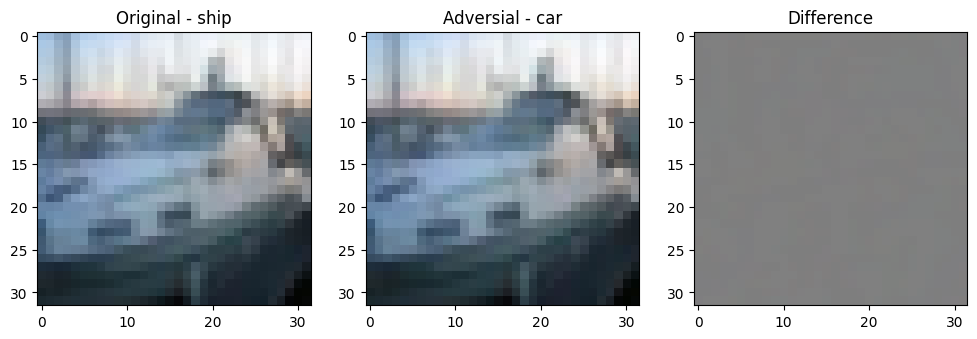

Image 3:
The attack was successful after 7 iterations


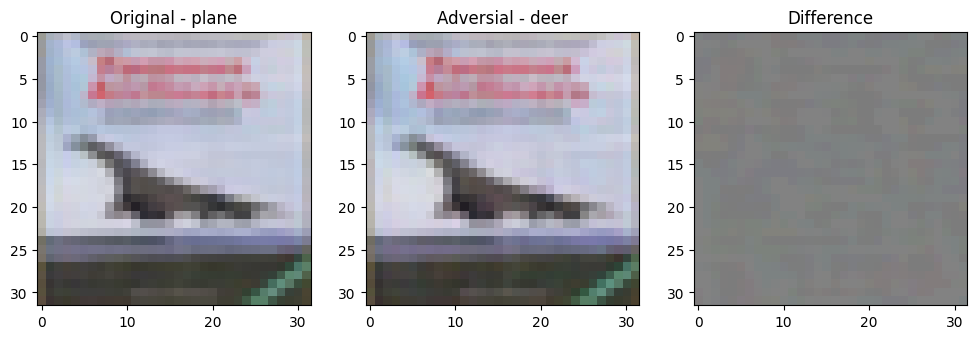

In [176]:
epsilon = 1/255
n_images = 4
criterion = nn.CrossEntropyLoss()
model.eval()

img, label = next(iter(testloader))
for i in range(n_images):
    print(f"Image {i}:")
    img_ex, label_ex = img[i].to(device), label[i].to(device)
    num_iter, orig_img, adv_img, pred = fgsm_attack(model, criterion, img_ex, label_ex, epsilon)
    show_attack(orig_img, label_ex, adv_img, pred, num_iter, inv, classes)

#### Quantitative evaluation (max iterations of the attacks is fixed to 10)

In [186]:
def attack_success_rate(results):
    # results is a list of tuples from fgsm_attack, (num_iterations, original_image, adversarial_image, predicted_label)
    success_count = sum([1 for r in results if r[0] not in (None, 0)])
    total = len(results)
    return success_count / total

def average_iterations(results):
    iterations = [r[0] for r in results if r[0] not in (None, 0)]
    if len(iterations) == 0:
        return None
    return sum(iterations) / len(iterations)

def confidence_drop(model, original_image, adversarial_image, true_label):
    ## (between the original image and the final adversarial image)
    with torch.no_grad():
        original_conf = torch.softmax(model(original_image.unsqueeze(0)), dim=1)[0, true_label].item()
        adv_conf = torch.softmax(model(adversarial_image.unsqueeze(0)), dim=1)[0, true_label].item()
    return original_conf - adv_conf

In [194]:
epsilons = [0.5/255, 1/255, 2/255, 4/255] 
n_images = 200
model.eval()

success_rates = []
avg_iterations_list = []
avg_conf_drops = []

for epsilon in epsilons:
    print(f"\nEvaluating FGSM attack with epsilon = {epsilon:.5f}")

    num_iters_list = []
    confidence_drops = []

    data_iter = iter(testloader)

    for _ in range(n_images):
        img, label = next(data_iter)
        img_ex, label_ex = img[0].to(device), label[0].to(device)

        num_iter, orig_img, adv_img, pred_label = fgsm_attack(model, criterion, img_ex, label_ex, epsilon)

        num_iters_list.append(num_iter)
        with torch.no_grad():
            orig_conf = torch.softmax(model(orig_img.unsqueeze(0)), dim=1)[0, label_ex].item()
            adv_conf = torch.softmax(model(adv_img.unsqueeze(0)), dim=1)[0, label_ex].item()
            confidence_drops.append(orig_conf - adv_conf if num_iter not in (None, 0) else 0.0)

    success_count = sum([1 for n in num_iters_list if n not in (None, 0)])
    success_rate = success_count / n_images
    avg_iterations = sum([n for n in num_iters_list if n not in (None, 0)]) / success_count if success_count > 0 else 0
    avg_conf_drop = sum([cd for i, cd in enumerate(confidence_drops) if num_iters_list[i] not in (None, 0)]) / success_count if success_count > 0 else 0

    success_rates.append(success_rate)
    avg_iterations_list.append(avg_iterations)
    avg_conf_drops.append(avg_conf_drop)

    print(f"Attack success rate: {success_rate:.3f}")
    print(f"Average iterations to success: {avg_iterations:.2f}")
    print(f"Average confidence drop: {avg_conf_drop:.3f}")


Evaluating FGSM attack with epsilon = 0.00196
Attack success rate: 0.365
Average iterations to success: 5.40
Average confidence drop: 0.647

Evaluating FGSM attack with epsilon = 0.00392
Attack success rate: 0.535
Average iterations to success: 4.66
Average confidence drop: 0.775

Evaluating FGSM attack with epsilon = 0.00784
Attack success rate: 0.630
Average iterations to success: 3.88
Average confidence drop: 0.883

Evaluating FGSM attack with epsilon = 0.01569
Attack success rate: 0.640
Average iterations to success: 2.81
Average confidence drop: 0.924


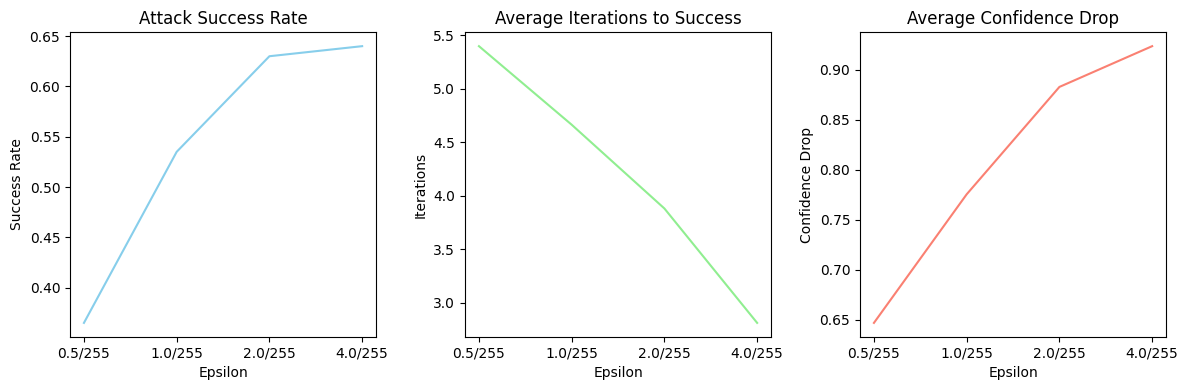

In [197]:
plt.figure(figsize=(12, 4))

# Use epsilon labels as multiples of 1/255
epsilon_labels = [f"{e*255:.1f}/255" for e in epsilons]

plt.subplot(1, 3, 1)
plt.plot(epsilon_labels, success_rates, color='skyblue')
plt.title("Attack Success Rate")
plt.xlabel("Epsilon")
plt.ylabel("Success Rate")

plt.subplot(1, 3, 2)
plt.plot(epsilon_labels, avg_iterations_list, color='lightgreen')
plt.title("Average Iterations to Success")
plt.xlabel("Epsilon")
plt.ylabel("Iterations")

plt.subplot(1, 3, 3)
plt.plot(epsilon_labels, avg_conf_drops, color='salmon')
plt.title("Average Confidence Drop")
plt.xlabel("Epsilon")
plt.ylabel("Confidence Drop")

plt.tight_layout()
plt.show()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [207]:
import torch
import numpy as np
from tqdm import tqdm

def train_epoch_with_adversarial(model, dataloader, loss_function, optimizer, epoch_number=0, device='cpu', epsilon=1/255):
    model.train()
    batch_losses = []
    progress_bar = tqdm(dataloader, total=len(dataloader))
    
    for batch_index, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        adversarial_inputs = inputs.clone().detach().requires_grad_(True)
        output_on_adv = model(adversarial_inputs)
        loss_on_adv = loss_function(output_on_adv, targets)
        
        model.zero_grad()
        loss_on_adv.backward()
        with torch.no_grad():
            adversarial_inputs += epsilon * torch.sign(adversarial_inputs.grad)
        
        output_on_clean = model(inputs)
        output_on_adv_final = model(adversarial_inputs.detach())
        
        clean_loss = loss_function(output_on_clean, targets)
        adv_loss = loss_function(output_on_adv_final, targets)
        
        combined_loss = 0.5 * (clean_loss + adv_loss)  
        
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()
        
        batch_losses.append(combined_loss.item())
        progress_bar.set_description(f"Epoch {epoch_number} - Average Loss: {np.mean(batch_losses):.5f}")
    
    return np.mean(batch_losses)

In [208]:
model = CNN().to(device)
loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50
epsilon = 1/255

for e in range(epochs):
  train_loss = train_epoch_with_adversarial(model, trainloader, loss, optimizer, epoch_number=e, device=device, epsilon=epsilon)
  val_loss, val_acc, val_report = evaluate_model(model, testloader, loss, device=device)
  print(f'Epoch {e} - Validation Loss: {val_loss} - Validation Accuracy: {val_acc}')
  
torch.save(model.state_dict(), './model_weights/cifar10_cnn_adv.pth')

Epoch 0 - Average Loss: 1.85706: 100%|██████████| 391/391 [00:52<00:00,  7.48it/s]


Epoch 0 - Validation Loss: 1.5435421738443496 - Validation Accuracy: 0.4367


Epoch 1 - Average Loss: 1.50875: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]


Epoch 1 - Validation Loss: 1.3731343384030499 - Validation Accuracy: 0.4946


Epoch 2 - Average Loss: 1.37409: 100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Epoch 2 - Validation Loss: 1.2806349645687054 - Validation Accuracy: 0.5344


Epoch 3 - Average Loss: 1.28260: 100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Epoch 3 - Validation Loss: 1.2356434713436077 - Validation Accuracy: 0.5536


Epoch 4 - Average Loss: 1.21046: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]


Epoch 4 - Validation Loss: 1.170735833011096 - Validation Accuracy: 0.5709


Epoch 5 - Average Loss: 1.14695: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 5 - Validation Loss: 1.1149787706664847 - Validation Accuracy: 0.5987


Epoch 6 - Average Loss: 1.08648: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]


Epoch 6 - Validation Loss: 1.0871731616273712 - Validation Accuracy: 0.6103


Epoch 7 - Average Loss: 1.03712: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 7 - Validation Loss: 1.058355204666717 - Validation Accuracy: 0.6237


Epoch 8 - Average Loss: 0.97749: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]


Epoch 8 - Validation Loss: 1.0291268010682697 - Validation Accuracy: 0.6344


Epoch 9 - Average Loss: 0.92365: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 9 - Validation Loss: 1.0046632652041279 - Validation Accuracy: 0.6412


Epoch 10 - Average Loss: 0.87531: 100%|██████████| 391/391 [01:22<00:00,  4.73it/s]


Epoch 10 - Validation Loss: 0.9860759309575527 - Validation Accuracy: 0.6533


Epoch 11 - Average Loss: 0.81582: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]


Epoch 11 - Validation Loss: 0.9963465959210939 - Validation Accuracy: 0.6577


Epoch 12 - Average Loss: 0.76555: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]


Epoch 12 - Validation Loss: 0.9821889830541007 - Validation Accuracy: 0.6587


Epoch 13 - Average Loss: 0.70907: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]


Epoch 13 - Validation Loss: 0.9549362848076639 - Validation Accuracy: 0.6714


Epoch 14 - Average Loss: 0.65027: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch 14 - Validation Loss: 0.9803837251059616 - Validation Accuracy: 0.6707


Epoch 15 - Average Loss: 0.59204: 100%|██████████| 391/391 [01:08<00:00,  5.72it/s]


Epoch 15 - Validation Loss: 1.0025316838976703 - Validation Accuracy: 0.6721


Epoch 16 - Average Loss: 0.53344: 100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Epoch 16 - Validation Loss: 0.9967313582384134 - Validation Accuracy: 0.6799


Epoch 17 - Average Loss: 0.47365: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]


Epoch 17 - Validation Loss: 1.0477896543997753 - Validation Accuracy: 0.6773


Epoch 18 - Average Loss: 0.40642: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]


Epoch 18 - Validation Loss: 1.1611453664453724 - Validation Accuracy: 0.6741


Epoch 19 - Average Loss: 0.34920: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s]


Epoch 19 - Validation Loss: 1.1704982209809218 - Validation Accuracy: 0.6746


Epoch 20 - Average Loss: 0.28609: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s]


Epoch 20 - Validation Loss: 1.2850336794611774 - Validation Accuracy: 0.6741


Epoch 21 - Average Loss: 0.23303: 100%|██████████| 391/391 [01:08<00:00,  5.75it/s]


Epoch 21 - Validation Loss: 1.4064711075794847 - Validation Accuracy: 0.6687


Epoch 22 - Average Loss: 0.18079: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s]


Epoch 22 - Validation Loss: 1.6261773879014993 - Validation Accuracy: 0.6476


Epoch 23 - Average Loss: 0.14220: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s]


Epoch 23 - Validation Loss: 1.7360054224352293 - Validation Accuracy: 0.6693


Epoch 24 - Average Loss: 0.11596: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]


Epoch 24 - Validation Loss: 1.804235162614267 - Validation Accuracy: 0.6691


Epoch 25 - Average Loss: 0.08985: 100%|██████████| 391/391 [01:07<00:00,  5.76it/s]


Epoch 25 - Validation Loss: 2.0421470886544335 - Validation Accuracy: 0.6697


Epoch 26 - Average Loss: 0.06869: 100%|██████████| 391/391 [01:07<00:00,  5.75it/s]


Epoch 26 - Validation Loss: 2.140099338338345 - Validation Accuracy: 0.6704


Epoch 27 - Average Loss: 0.07140: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]


Epoch 27 - Validation Loss: 2.199083716054506 - Validation Accuracy: 0.6613


Epoch 28 - Average Loss: 0.06435: 100%|██████████| 391/391 [01:08<00:00,  5.75it/s]


Epoch 28 - Validation Loss: 2.3522430401814134 - Validation Accuracy: 0.6628


Epoch 29 - Average Loss: 0.05769: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]


Epoch 29 - Validation Loss: 2.4112870119795016 - Validation Accuracy: 0.6607


Epoch 30 - Average Loss: 0.03764: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s]


Epoch 30 - Validation Loss: 2.5572266820110854 - Validation Accuracy: 0.6657


Epoch 31 - Average Loss: 0.03979: 100%|██████████| 391/391 [01:23<00:00,  4.67it/s]


Epoch 31 - Validation Loss: 2.6341417092311232 - Validation Accuracy: 0.6673


Epoch 32 - Average Loss: 0.05613: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]


Epoch 32 - Validation Loss: 2.4872430427164973 - Validation Accuracy: 0.6588


Epoch 33 - Average Loss: 0.04486: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 33 - Validation Loss: 2.6412697562688514 - Validation Accuracy: 0.6712


Epoch 34 - Average Loss: 0.02566: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 34 - Validation Loss: 2.775137498408933 - Validation Accuracy: 0.6686


Epoch 35 - Average Loss: 0.03342: 100%|██████████| 391/391 [01:08<00:00,  5.70it/s]


Epoch 35 - Validation Loss: 2.767122875286054 - Validation Accuracy: 0.6686


Epoch 36 - Average Loss: 0.04164: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Epoch 36 - Validation Loss: 2.8617034260230727 - Validation Accuracy: 0.6626


Epoch 37 - Average Loss: 0.02010: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 37 - Validation Loss: 2.8433115935023827 - Validation Accuracy: 0.6711


Epoch 38 - Average Loss: 0.02078: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 38 - Validation Loss: 3.033237116246284 - Validation Accuracy: 0.6614


Epoch 39 - Average Loss: 0.05641: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]


Epoch 39 - Validation Loss: 2.7286203420614896 - Validation Accuracy: 0.6692


Epoch 40 - Average Loss: 0.01871: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 40 - Validation Loss: 2.939576161058643 - Validation Accuracy: 0.6612


Epoch 41 - Average Loss: 0.01716: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 41 - Validation Loss: 3.024741432334803 - Validation Accuracy: 0.666


Epoch 42 - Average Loss: 0.03982: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Epoch 42 - Validation Loss: 2.866365040404887 - Validation Accuracy: 0.6618


Epoch 43 - Average Loss: 0.02765: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


Epoch 43 - Validation Loss: 3.0767762751518926 - Validation Accuracy: 0.6667


Epoch 44 - Average Loss: 0.02023: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]


Epoch 44 - Validation Loss: 3.0839618519891667 - Validation Accuracy: 0.6724


Epoch 45 - Average Loss: 0.01083: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch 45 - Validation Loss: 3.2412489697903015 - Validation Accuracy: 0.6685


Epoch 46 - Average Loss: 0.02470: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]


Epoch 46 - Validation Loss: 3.1724627440488793 - Validation Accuracy: 0.6574


Epoch 47 - Average Loss: 0.04110: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]


Epoch 47 - Validation Loss: 3.0650236636777466 - Validation Accuracy: 0.6641


Epoch 48 - Average Loss: 0.02381: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 48 - Validation Loss: 2.993893502633783 - Validation Accuracy: 0.6707


Epoch 49 - Average Loss: 0.01122: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]


Epoch 49 - Validation Loss: 3.187802842900723 - Validation Accuracy: 0.6653


In [314]:
model = CNN().to(device)
model.load_state_dict(torch.load('./model_weights/cifar10_cnn_adv.pth', map_location=device))

<All keys matched successfully>

In [315]:
batch_size = 128
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [316]:
score_fun = max_softmax

scores_test = compute_scores(testloader, score_fun) 
scores_fake = compute_scores(fakeloader, score_fun)

In [317]:
prediction = torch.cat((scores_test, scores_fake))
target = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))

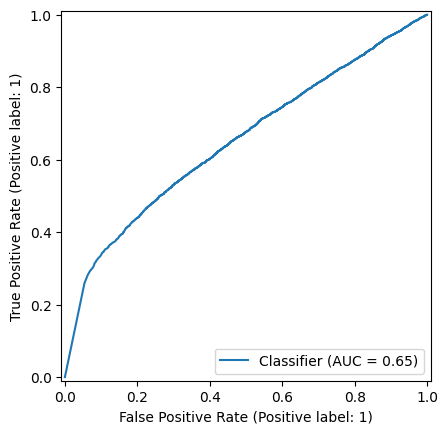

In [318]:
metrics.RocCurveDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

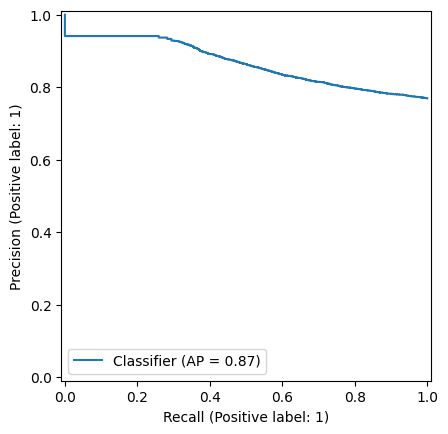

In [319]:
metrics.PrecisionRecallDisplay.from_predictions(target.cpu().numpy(), prediction.cpu().numpy())

In [320]:
epsilons = [0.5/255, 1/255, 2/255, 4/255]
n_images = 200 
model.eval()  
success_rates = []
avg_iterations_list = []
avg_conf_drops = []

for epsilon in epsilons:
    print(f"\nEvaluating FGSM attack with epsilon = {epsilon:.5f}")

    num_iters_list = []
    confidence_drops = []

    count = 0
    for img, label in testloader:
        img_ex, label_ex = img[0].to(device), label[0].to(device)  # single image

        num_iter, orig_img, adv_img, pred_label = fgsm_attack(model, criterion, img_ex, label_ex, epsilon)

        num_iters_list.append(num_iter)

        with torch.no_grad():
            orig_conf = torch.softmax(model(orig_img.unsqueeze(0)), dim=1)[0, label_ex].item()
            adv_conf = torch.softmax(model(adv_img.unsqueeze(0)), dim=1)[0, label_ex].item()
            confidence_drops.append(orig_conf - adv_conf if num_iter not in (None, 0) else 0.0)

        count += 1
        if count >= n_images:
            break  

    success_count = sum([1 for n in num_iters_list if n not in (None, 0)])
    success_rate = success_count / n_images
    avg_iterations = sum([n for n in num_iters_list if n not in (None, 0)]) / success_count if success_count > 0 else 0
    avg_conf_drop = sum([cd for i, cd in enumerate(confidence_drops) if num_iters_list[i] not in (None, 0)]) / success_count if success_count > 0 else 0

    success_rates.append(success_rate)
    avg_iterations_list.append(avg_iterations)
    avg_conf_drops.append(avg_conf_drop)

    print(f"Attack success rate: {success_rate:.3f}")
    print(f"Average iterations to success: {avg_iterations:.2f}")
    print(f"Average confidence drop: {avg_conf_drop:.3f}")


Evaluating FGSM attack with epsilon = 0.00196
Attack success rate: 0.130
Average iterations to success: 6.81
Average confidence drop: 0.664

Evaluating FGSM attack with epsilon = 0.00392
Attack success rate: 0.175
Average iterations to success: 4.97
Average confidence drop: 0.774

Evaluating FGSM attack with epsilon = 0.00784
Attack success rate: 0.230
Average iterations to success: 4.22
Average confidence drop: 0.870

Evaluating FGSM attack with epsilon = 0.01569
Attack success rate: 0.250
Average iterations to success: 3.28
Average confidence drop: 0.925


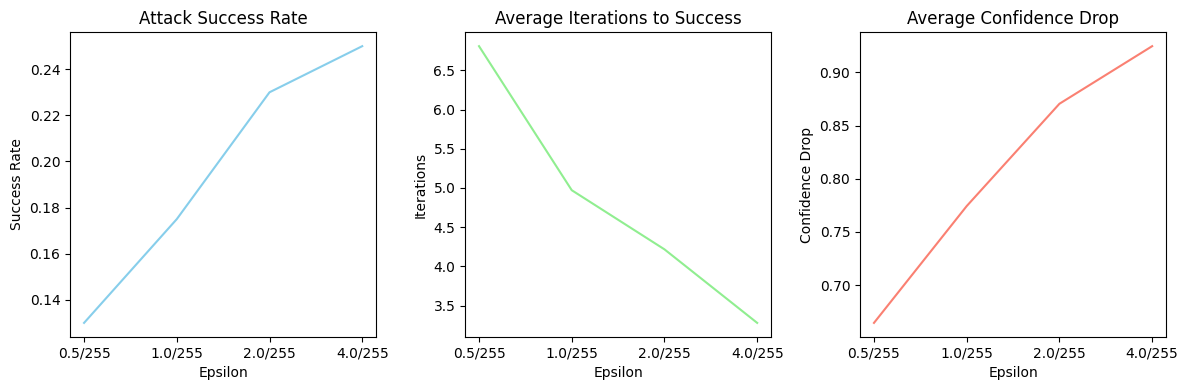

In [321]:
plt.figure(figsize=(12, 4))

epsilon_labels = [f"{e*255:.1f}/255" for e in epsilons]

plt.subplot(1, 3, 1)
plt.plot(epsilon_labels, success_rates, color='skyblue')
plt.title("Attack Success Rate")
plt.xlabel("Epsilon")
plt.ylabel("Success Rate")

plt.subplot(1, 3, 2)
plt.plot(epsilon_labels, avg_iterations_list, color='lightgreen')
plt.title("Average Iterations to Success")
plt.xlabel("Epsilon")
plt.ylabel("Iterations")

plt.subplot(1, 3, 3)
plt.plot(epsilon_labels, avg_conf_drops, color='salmon')
plt.title("Average Confidence Drop")
plt.xlabel("Epsilon")
plt.ylabel("Confidence Drop")

plt.tight_layout()
plt.show()


### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


#### FGSM Extension: Targeted Attacks

Extend `fgsm_attack` function to supports both **non-targeted** and **targeted attacks**.

note the change of sign and the different loss

In [323]:
def fgsm_attack(model, loss_fn, input_image, true_label, epsilon, target_label=None, max_iterations=10):
    original_image = input_image.clone().detach()
    adversarial_image = input_image.clone().detach()
    adversarial_image.requires_grad = True

    output = model(adversarial_image.unsqueeze(0))
    predicted_label = output.argmax().item()

    if target_label is None and predicted_label != true_label.item():
        return 0, original_image, adversarial_image.detach(), predicted_label
    if target_label is not None and predicted_label == target_label.item():
        return 0, original_image, adversarial_image.detach(), predicted_label

    for iteration in range(1, max_iterations + 1):
        output = model(adversarial_image.unsqueeze(0))

        if target_label is None:
            loss = loss_fn(output, true_label.unsqueeze(0))
        else:
            loss = loss_fn(output, target_label.unsqueeze(0))

        predicted_label = output.argmax().item()

        if target_label is None:
            if predicted_label != true_label.item():
                return iteration, original_image, adversarial_image.detach(), predicted_label
        else:
            if predicted_label == target_label.item():
                return iteration, original_image, adversarial_image.detach(), predicted_label

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            if target_label is None:  # non-targeted
                adversarial_image += epsilon * torch.sign(adversarial_image.grad)
            else:  # targeted
                adversarial_image -= epsilon * torch.sign(adversarial_image.grad)

        adversarial_image.requires_grad = True

    return None, original_image, adversarial_image.detach(), predicted_label


def show_attack(original_image, true_label, adversarial_image, predicted_label, num_iterations, inv_transform,
                class_names, target_label=None):
    if num_iterations is None:
        print("Attack failed")
    elif num_iterations == 0:
        if target_label is None:
            print("No attack: image already misclassified")
        else:
            print(f"No attack: image already classified as target {class_names[target_label.item()]}")
    else:
        if target_label is None:
            print(f"Non-targeted attack successful after {num_iterations} iterations")
        else:
            print(
                f"Targeted attack successful after {num_iterations} iterations (target {class_names[target_label.item()]})")

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(inv_transform(original_image).permute(1, 2, 0).cpu().detach())
        axes[0].set_title(f"Original - {class_names[true_label.item()]}")
        axes[1].imshow(inv_transform(adversarial_image).permute(1, 2, 0).cpu().detach())
        axes[1].set_title(f"Adversarial - {class_names[predicted_label]}")
        axes[2].imshow(inv_transform(original_image - adversarial_image).permute(1, 2, 0).cpu().detach())
        axes[2].set_title("Difference")
        plt.show()

#### I test the targeted and not targeted attack on the model from the previous exercise

### NON TARGETED ATTACK

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.060784206..1.0098042].


Image 0:
Non-targeted attack successful after 6 iterations


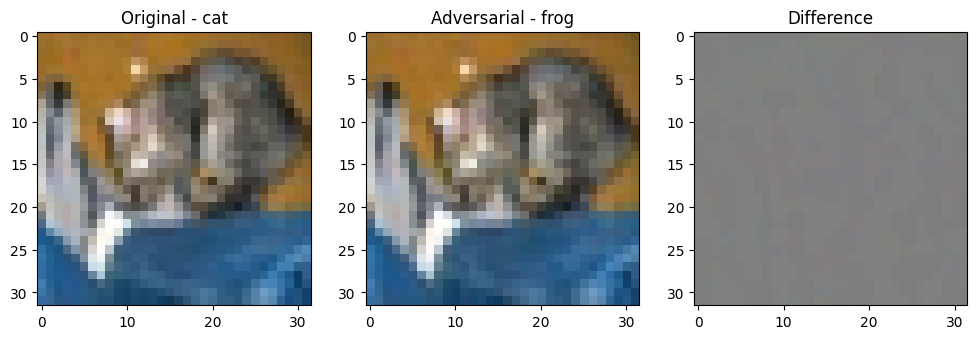

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..0.9686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017647449..0.9862746].


Image 1:
Non-targeted attack successful after 10 iterations


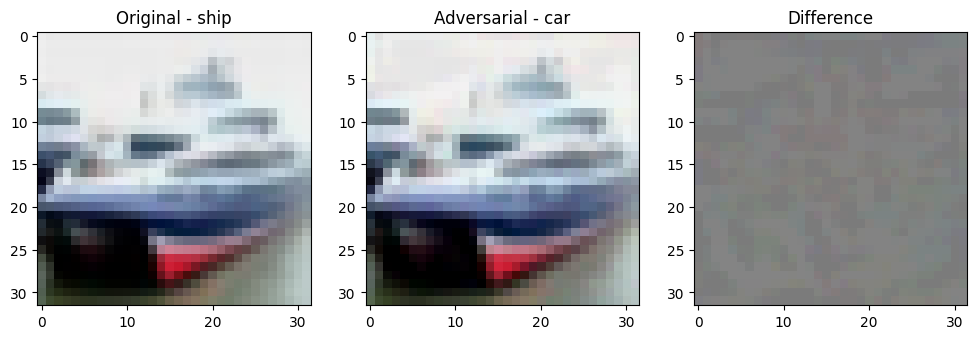

Image 2:
Non-targeted attack successful after 5 iterations


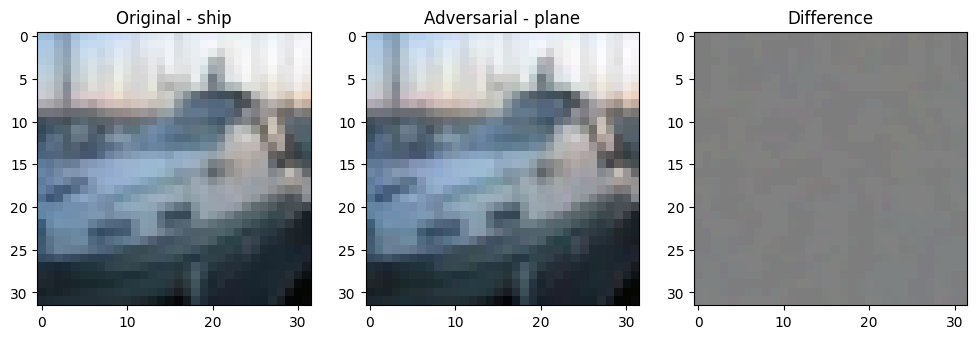

Image 3:
Non-targeted attack successful after 6 iterations


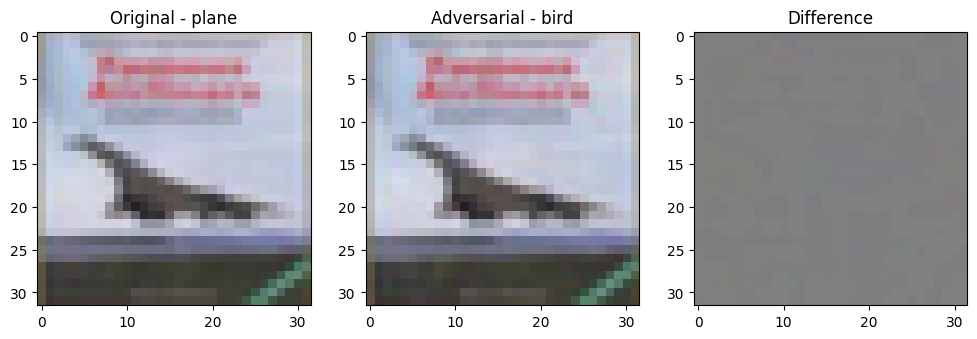

Image 4:
Non-targeted attack successful after 3 iterations


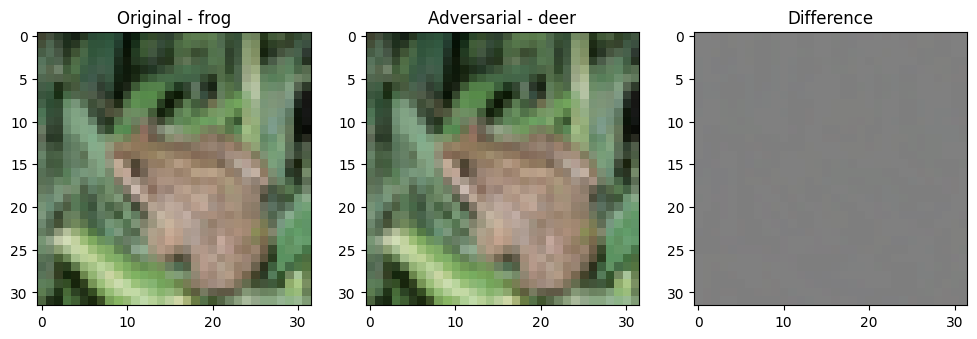

In [335]:
epsilon = 1/255
n_images = 5
max_iterations = 20
criterion = nn.CrossEntropyLoss()
model.eval()

img, label = next(iter(testloader))
for i in range(n_images):
    print(f"Image {i}:")
    img_ex, label_ex = img[i].to(device), label[i].to(device)
    
    num_iter, orig_img, adv_img, pred = fgsm_attack(
        model, criterion, img_ex, label_ex, epsilon, max_iterations=max_iterations
    )
    
    show_attack(orig_img, label_ex, adv_img, pred, num_iter, inv, classes)

#### TARGETED ATTACK

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054901853..1.0156866].


Image 0:
Targeted attack successful after 9 iterations (target dog)


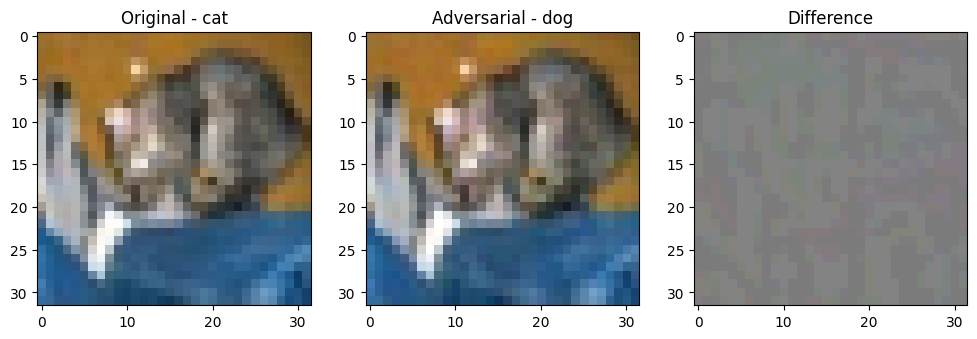

Image 1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0019606655..1.0176475].


Attack failed
Image 2:
Targeted attack successful after 16 iterations (target dog)


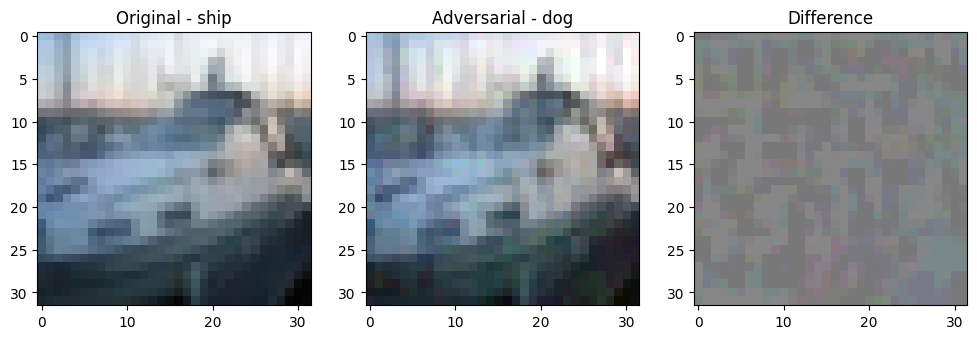

Image 3:
Attack failed
Image 4:
Targeted attack successful after 10 iterations (target dog)


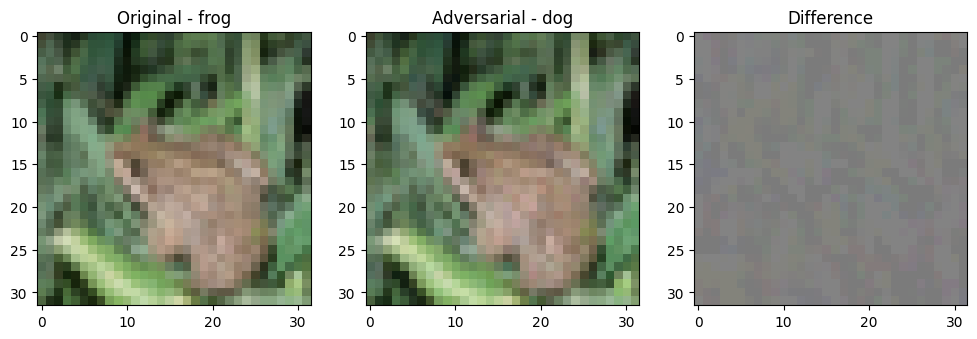

In [337]:
target_class = torch.tensor(5, device=device) # dog

for i in range(n_images):
    print(f"Image {i}:")
    img_ex, label_ex = img[i].to(device), label[i].to(device)

    num_iter, orig_img, adv_img, pred = fgsm_attack(
        model, criterion, img_ex, label_ex, epsilon, target_label=target_class, max_iterations=max_iterations
    )
    
    show_attack(orig_img, label_ex, adv_img, pred, num_iter, inv, classes, target_label=target_class)

#### From these 5 sample it looks like the number of iterations needed for successful targeted attacks is higher, let's check if this behavior is global

### Quantitative evaluation for targeted attacks

In [338]:
epsilons = [0.5/255, 1/255, 2/255, 4/255]
n_images = 200 
model.eval()  

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [347]:
epsilons = [0.5/255, 1/255, 2/255, 4/255]
n_images = 200
max_iterations = 10
target_class = torch.tensor(5, device=device)  # fixed target class
model.eval()

success_rates_nt, avg_iterations_nt, avg_conf_drops_nt = [], [], []
success_rates_t, avg_iterations_t, avg_conf_drops_t = [], [], []

for epsilon in epsilons:
    print(f"\nEvaluating FGSM attacks with epsilon = {epsilon:.5f}")
    
    num_iters_list_nt, conf_drops_nt = [], []
    num_iters_list_t, conf_drops_t = [], []
    
    count = 0
    for img, label in testloader:
        img_ex, label_ex = img[0].to(device), label[0].to(device)

        # non-targeted attack 
        num_iter_nt, orig_img_nt, adv_img_nt, _ = fgsm_attack(
            model, criterion, img_ex, label_ex, epsilon, max_iterations=max_iterations
        )
        num_iters_list_nt.append(num_iter_nt)
        with torch.no_grad():
            orig_conf = torch.softmax(model(orig_img_nt.unsqueeze(0)), dim=1)[0, label_ex].item()
            adv_conf = torch.softmax(model(adv_img_nt.unsqueeze(0)), dim=1)[0, label_ex].item()
            conf_drops_nt.append(orig_conf - adv_conf if num_iter_nt not in (None, 0) else 0.0)

        # targeted attack 
        num_iter_t, orig_img_t, adv_img_t, _ = fgsm_attack(
            model, criterion, img_ex, label_ex, epsilon, target_label=target_class, max_iterations=max_iterations
        )
        num_iters_list_t.append(num_iter_t)
        with torch.no_grad():
            orig_conf = torch.softmax(model(orig_img_t.unsqueeze(0)), dim=1)[0, label_ex].item()
            adv_conf = torch.softmax(model(adv_img_t.unsqueeze(0)), dim=1)[0, label_ex].item()
            conf_drops_t.append(orig_conf - adv_conf if num_iter_t not in (None, 0) else 0.0)

        count += 1
        if count >= n_images:
            break

    success_count_nt = sum([1 for n in num_iters_list_nt if n not in (None, 0)])
    success_rates_nt.append(success_count_nt / n_images)
    avg_iterations_nt.append(sum([n for n in num_iters_list_nt if n not in (None, 0)]) / success_count_nt if success_count_nt > 0 else 0)
    avg_conf_drops_nt.append(sum([cd for i, cd in enumerate(conf_drops_nt) if num_iters_list_nt[i] not in (None, 0)]) / success_count_nt if success_count_nt > 0 else 0)

    success_count_t = sum([1 for n in num_iters_list_t if n not in (None, 0)])
    success_rates_t.append(success_count_t / n_images)
    avg_iterations_t.append(sum([n for n in num_iters_list_t if n not in (None, 0)]) / success_count_t if success_count_t > 0 else 0)
    avg_conf_drops_t.append(sum([cd for i, cd in enumerate(conf_drops_t) if num_iters_list_t[i] not in (None, 0)]) / success_count_t if success_count_t > 0 else 0)


Evaluating FGSM attacks with epsilon = 0.00196

Evaluating FGSM attacks with epsilon = 0.00392

Evaluating FGSM attacks with epsilon = 0.00784

Evaluating FGSM attacks with epsilon = 0.01569


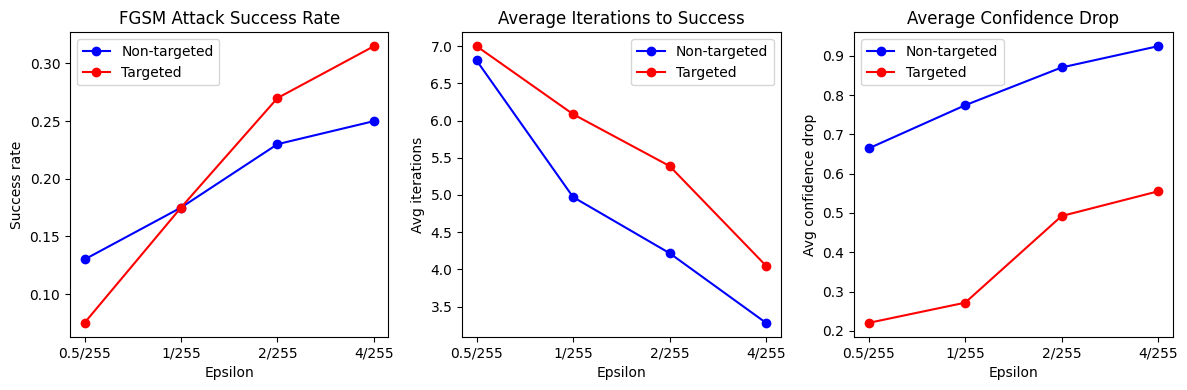

In [348]:
epsilons_plot = ['0.5/255', '1/255', '2/255', '4/255']

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(epsilons_plot, success_rates_nt, label='Non-targeted', color='blue', marker='o')
plt.plot(epsilons_plot, success_rates_t, label='Targeted', color='red', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Success rate')
plt.title('FGSM Attack Success Rate')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epsilons_plot, avg_iterations_nt, label='Non-targeted', color='blue', marker='o')
plt.plot(epsilons_plot, avg_iterations_t, label='Targeted', color='red', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Avg iterations')
plt.title('Average Iterations to Success')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epsilons_plot, avg_conf_drops_nt, label='Non-targeted', color='blue', marker='o')
plt.plot(epsilons_plot, avg_conf_drops_t, label='Targeted', color='red', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Avg confidence drop')
plt.title('Average Confidence Drop')
plt.legend()

plt.tight_layout()
plt.show()